In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from src.encoders_decoders import *
from src.losses import *

# Part I: loss and MSE visualization

In [220]:
N = 20

#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.4).sample((1000,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 

#encoder = CategoricalEncoder(mu0,sigma0,q0)
#decoder = MoGDecoder(N,x_min,x_max)
decoder = MoGDecoder(N,x_min,x_max)
decoder.log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N))[:,None])
encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))

#Define optimizer and parameters to iterate on
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params,lr=0.001)
loss = distortion_cat(x_data, encoder, decoder) + rate_cat(x_data, encoder, decoder)

In [221]:
loss_class = []
mse_val = []

for i in range(1,4000):
    running_loss_tot=0
    running_mse=0
   
    loss = distortion_cat(x_data, encoder, decoder) + rate_cat(x_data, encoder, decoder)
    mse=MSE_cat(x_data, decoder, encoder)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    running_loss_tot = loss.item()
    running_mse = mse.item()

    
    loss_class.append(running_loss_tot)
    mse_val.append(running_mse)
   


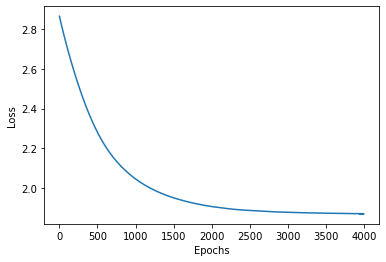

In [222]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_class) 

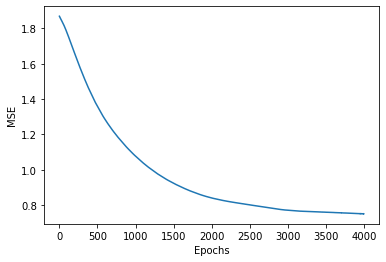

In [223]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(mse_val)

# Encoding

<ipython-input-224-9548d405fd28>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,6]))


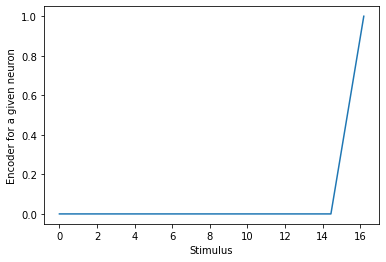

In [224]:
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoder for a given neuron")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,6]))   

<ipython-input-225-d6e3f776e5d9>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:]))


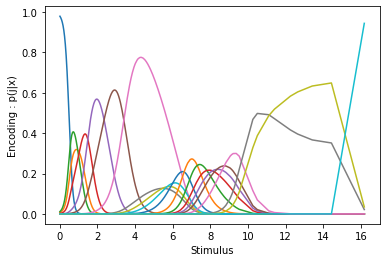

In [225]:
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding : p(j|x)")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:]))   
    

# Decoding

In [226]:
encoder.sample(x_sorted,10)

tensor([[ 0,  0,  0,  ..., 18, 18, 19],
        [ 0,  0,  0,  ..., 17, 18, 19],
        [ 0,  0,  0,  ..., 17, 18, 19],
        ...,
        [ 0,  0,  0,  ..., 18, 17, 19],
        [ 0,  0,  0,  ..., 18, 17, 19],
        [ 0,  0,  0,  ..., 17, 17, 19]])

In [227]:
r = encoder
mu_dec, sigma_dec = dec(x_sorted)

NameError: name 'dec' is not defined

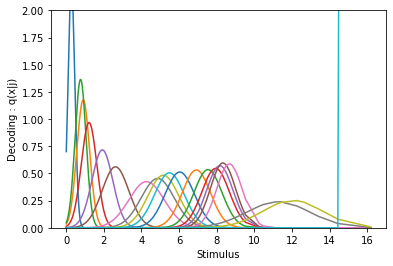

In [230]:
gaussian = torch.distributions.normal.Normal(decoder.mus, torch.exp(decoder.log_sigmas))
a = (gaussian.log_prob(x_sorted.transpose(0,1))).transpose(0,1)
with torch.no_grad():
    plt.plot(x_sorted, torch.exp(a[:,:]))
    plt.xlabel("Stimulus")
    plt.ylabel("Decoding : q(x|j)")
    plt.ylim((0,2))
    
    

# Reconstruction error

In [231]:
#to visualize the error, use the first return in the GaussianDecoder

q_sample = torch.squeeze(torch.distributions.categorical.Categorical((F.softmax(decoder.qs,dim=0)).transpose(0,1)).sample((10000,)))
q_sample

tensor([ 5, 13,  0,  ...,  2,  0,  2])

In [232]:
muext,log_sigmaext =decoder(F.one_hot(q_sample).to(dtype=torch.float32))
x_sample = torch.flatten(torch.distributions.normal.Normal(muext,torch.exp(log_sigmaext)).sample((100,)))

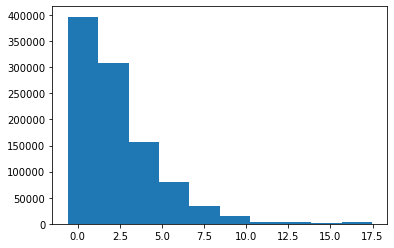

In [233]:
with torch.no_grad():
    
    plt.hist(x_sample.numpy())

In [234]:
x_sample_sort,indices = x_sample.sort(dim=0)
x_sample_sort.shape
#x_sorted.shape

torch.Size([1000000])

In [235]:
error = abs(x_sample_sort - x_sorted)   #| reconstructed_x via generative model -  x_data|
plt.plot(error)

KeyboardInterrupt: 

# MSE

Computing the loss as Mean Squared Erros + KL Divergence

In [236]:
optimizer = torch.optim.SGD(params,lr=0.001,momentum=0.9)
loss = MSE(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)

NameError: name 'MSE' is not defined

In [53]:
loss_mse = []
mse_val1 = []

for i in range(1,4000):
    running_loss_tot=0
    running_mse_val1=0
    
    
    loss = MSE(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)
    mse1=MSE(x_data, encoder, decoder)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    running_loss_tot = loss.item()
    running_mse_val1=mse1.item()
    loss_mse.append(running_loss_tot)
    mse_val1.append(running_mse_val1)

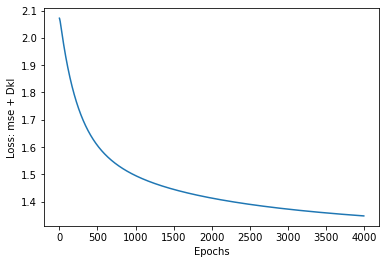

In [54]:
plt.xlabel("Epochs")
plt.ylabel("Loss: mse + Dkl")
plt.plot(loss_mse) 


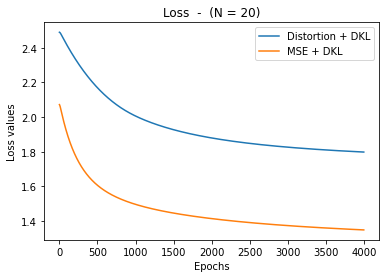

In [55]:
plt.plot(loss_class, label = "Distortion + DKL")
plt.plot(loss_mse, label = "MSE + DKL")
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title('Loss  -  (N = 20)')
plt.legend()

plt.show()

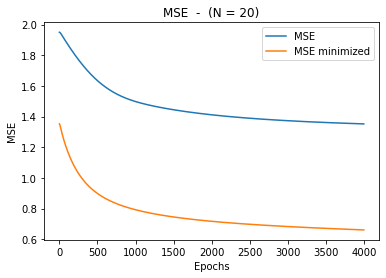

In [56]:
plt.plot(mse_val, label = "MSE")
plt.plot(mse_val1, label = "MSE minimized")
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE  -  (N = 20)')
plt.legend()

plt.show()

# Loss behaviour for different N values

In [237]:

x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)

#TRAINING FUNCTION (to move in a script)

def training(N):
    #parameters initialization
    mu0 = torch.arange(0,10,10/N)[None,:]
    sigma0 = torch.ones(N)[None,:]
    q0 = 1/N*torch.ones(N)[None,:]
    
    #model and parameters
    #encoder = CategoricalEncoder(mu0,sigma0,q0)
    #decoder = GaussianDecoder(mu0,sigma0,q0)
    decoder=MoGDecoder(N,x_min,x_max)
    encoder=CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))
   
    params = list(decoder.parameters()) + list(encoder.parameters())
    optimizer = torch.optim.SGD(params,lr=0.01,momentum=0.9)
    loss = distortion_cat(x_data, encoder, decoder) + rate_cat(x_data, encoder, decoder)
    
    #training
    loss_val = []
    mse_val = []
    for i in range(1,8000):
        running_loss=0
        running_mse=0
   
        loss = distortion_cat(x_data, encoder, decoder) + rate_cat(x_data, encoder, decoder)
        mse=MSE_cat(x_data, decoder, encoder)

        optimizer.zero_grad()
        loss.backward()
    
        optimizer.step()
    
        running_loss = loss.item()
        running_mse = mse.item()

    
        loss_val.append(running_loss)
        mse_val.append(running_mse)
        
    
    return loss_val, mse_val
       
   

In [245]:
loss_10 , mse_10 = training(10)
loss_15 , mse_15 = training(15)
loss_20 , mse_20 = training(20)
loss_25 , mse_25 = training(25)
loss_30 , mse_30 = training(30)
loss_35 , mse_35 = training(35)
loss_40 , mse_40 = training(40)
loss_45 , mse_45 = training(45)
loss_50 , mse_50 = training(50)
loss_55 , mse_55 = training(55)
loss_60 , mse_60 = training(60)
NVec = range(10,60,5)

KeyboardInterrupt: 

In [248]:
NVec = range(10,60,5)
NVec

range(10, 60, 5)

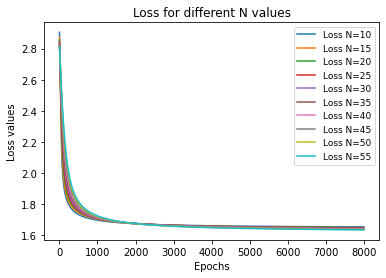

In [239]:
plt.plot(loss_10, label = "Loss N=10")
plt.plot(loss_15, label = "Loss N=15")
plt.plot(loss_20, label = "Loss N=20")
plt.plot(loss_25, label = "Loss N=25")
plt.plot(loss_30, label = "Loss N=30")
plt.plot(loss_35, label = "Loss N=35")
plt.plot(loss_40, label = "Loss N=40")
plt.plot(loss_45, label = "Loss N=45")
plt.plot(loss_50, label = "Loss N=50")
plt.plot(loss_55, label = "Loss N=55")

plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.title( 'Loss for different N values')
plt.legend(loc = "upper right", prop={'size': 9})

plt.show()

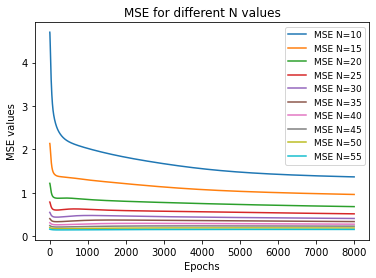

In [240]:
plt.plot(mse_10, label = "MSE N=10")
plt.plot(mse_15, label = "MSE N=15")
plt.plot(mse_20, label = "MSE N=20")
plt.plot(mse_25, label = "MSE N=25")
plt.plot(mse_30, label = "MSE N=30")
plt.plot(mse_35, label = "MSE N=35")
plt.plot(mse_40, label = "MSE N=40")
plt.plot(mse_45, label = "MSE N=45")
plt.plot(mse_50, label = "MSE N=50")
plt.plot(mse_55, label = "MSE N=55")

plt.xlabel('Epochs')
plt.ylabel('MSE values')
plt.title('MSE for different N values')
plt.legend(loc = "upper right", prop={'size': 9})

plt.show()

In [244]:
[mse_N[-1] for N in NVec]

SyntaxError: invalid syntax (<ipython-input-244-eac96365e0c4>, line 1)